This demo shows how to use the `nnbits` repository by 

1. generating the avalanche dataset for round 7 of Speck 32/64
2. exploring the computational resources
3. running an ensemble neural network analysis

It reproduces the corresponding results from the manuscript.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Install-Requirements" data-toc-modified-id="Install-Requirements-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Install Requirements</a></span></li><li><span><a href="#Choose-a-round-to-analyze" data-toc-modified-id="Choose-a-round-to-analyze-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Choose a round to analyze</a></span></li><li><span><a href="#Generate-avalanche-data" data-toc-modified-id="Generate-avalanche-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generate avalanche data</a></span></li><li><span><a href="#Have-a-look-at-the-available-resources" data-toc-modified-id="Have-a-look-at-the-available-resources-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Have a look at the available resources</a></span></li><li><span><a href="#Run-nnbits-neural-network-analysis" data-toc-modified-id="Run-nnbits-neural-network-analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Run <code>nnbits</code> neural network analysis</a></span></li><li><span><a href="#Analyze-the-results" data-toc-modified-id="Analyze-the-results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Analyze the results</a></span></li></ul></div>

# How to use this demo?
Please execute the following cells by pressing 

`Shift + Enter`

If you are using Google Colab, please enable GPU support by clicking on `Runtime > Change Runtime Type > Hardware accelerator "GPU" > Save`. 

# Install Requirements 

Clone the GitHub repository:

In [ ]:
!git clone https://github.com/Crypto-TII/nnbits

In [ ]:
%cd nnbits

Clone the GitHub repository:

In [ ]:
!git clone https://github.com/Crypto-TII/nnbits

In [2]:
%cd nnbits

/opt/cryptanalysis_servers_shared_folder/NNBits/10_main_code/nnbits


The following modules are required: 

In [3]:
%cat requirements.txt

cat: requirements.txt: No such file or directory


Install the requirements by running the following cell. 

In [ ]:
!pip install -r requirements.txt

# Choose a round to analyze 

In [2]:
# Here we will analyze round 7 of Speck 32/64.
# The corresponding round-id is round 6 (we start counting the round-id from zero):
ROUND_IDs = [6]

# Generate avalanche data 

Create a folder for the data

In [8]:
!mkdir 'speck_32_64'

Generate `number_of_samples = 300_000` avalanche units

In [10]:
#### CONFIGURATION ######

number_of_samples = 300_000

#########################

from avalanche_data_generator.speck_32_64 import speck_k64_p32_o32_r22 as data_generator
import numpy as np

dataset=data_generator.generate_avalanche_dataset(int(number_of_samples))

for r in ROUND_IDs:
    np.save(f"speck_32_64/round{r}_sequences300k.npy", dataset[ROUND_ID])

# Have a look at the available resources 

The Nvidia A100-DGX server provides 

* `4 A100-SXM GPUs, each with 40'536 MiB memory (and in addition a graphical GPU)` 
* `128 CPU cores`

In comparison, the free Google Colaboratory provides

* `1 Tesla T4 GPU with 15'109 MiB memory`
* `2 CPU cores`

The available resources can be explored by using for example the `ray.available_resources()` or `nvidia-smi`:

In [1]:
import ray
ray.init()
ray.available_resources()

{'GPU': 5.0,
 'object_store_memory': 94416284467.0,
 'memory': 210304663757.0,
 'CPU': 128.0,
 'node:172.31.102.80': 1.0}

In [2]:
!nvidia-smi

Sat Jun  4 10:54:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   36C    P0    51W / 275W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:47:00.0 Off |                    0 |
| N/A   

# Run `nnbits` neural network analysis 

If you are executing the Notebook on <font color='blue'>Google Colaboratory, please change</font> the following four lines in the cell below:

```python
...
'N_GPUS': 1, 
'N_ACTORS_PER_GPU': 2,
'GPU_PER_ACTOR': 0.5,
'CPU_PER_ACTOR': 0.5 ,
...
```

In [13]:
import toml
from nnbits.filemanager import FileManager

for r in ROUND_IDs:
    
    # choose where to save the data
    savepath = f'demo_speck32_roundid{r}'
    !rm -r '{savepath}'
    !mkdir '{savepath}'
    
    # choose the settings
    config = {'DATAPATH': f'speck_32_64/round{r}_sequences300k.npy',
               # ensemble settings
                 'NEURAL_NETWORK_MODEL': 'gohr_generalized', 
                 'NEURAL_NETWORKS': 100, 
                 'SELECT_BITS_STRATEGY': 'random', 
                 'INPUT_DATA_OP': 'zero', 
                 'N_RANDOM_BITS': 63,
               # hardware settings
                 'N_GPUS': 4,
                 'N_ACTORS_PER_GPU': 6,
                 'GPU_PER_ACTOR': 0.15,
                 'CPU_PER_ACTOR': 5, 
               # training settings
                 'N_EPOCHS': 5,
                 'N_TRAIN': 145_000,
                 'N_VAL': 145_000,
                 'BATCHSIZE': 5000}
    
    # save the configuration file
    F = FileManager(savepath)

    with open(F.filename_config(), 'w') as configfile:
        toml.dump(config, configfile)
        
    #============ run the analysis ============
    !python -m nnbits.run --savepath '{savepath}'

|                             | value                                |
|:----------------------------|:-------------------------------------|
| DATAPATH                    | speck_32_64/round6_sequences300k.npy |
| NEURAL_NETWORK_MODEL        | gohr_generalized                     |
| NEURAL_NETWORKS             | 100                                  |
| SELECT_BITS_STRATEGY        | random                               |
| INPUT_DATA_OP               | zero                                 |
| N_RANDOM_BITS               | 63                                   |
| N_GPUS                      | 4                                    |
| N_ACTORS_PER_GPU            | 6                                    |
| GPU_PER_ACTOR               | 0.15                                 |
| CPU_PER_ACTOR               | 5                                    |
| N_EPOCHS                    | 5                                    |
| N_TRAIN                     | 145000                               |
| N_VA

# Analyze the results 

In [5]:
import numpy as np

Each neural network has been tested on the test-data and the results are saved in the `test_accuracies` folder:

In [6]:
!ls 'demo_speck32_roundid6'

bit_selections	h5    run_log.pkl      test_accuracies_bit_by_bit
config.cfg	hist  test_accuracies


In [7]:
!ls 'demo_speck32_roundid6/test_accuracies'

0.npy	19.npy	28.npy	37.npy	46.npy	55.npy	64.npy	73.npy	82.npy	91.npy
10.npy	1.npy	29.npy	38.npy	47.npy	56.npy	65.npy	74.npy	83.npy	92.npy
11.npy	20.npy	2.npy	39.npy	48.npy	57.npy	66.npy	75.npy	84.npy	93.npy
12.npy	21.npy	30.npy	3.npy	49.npy	58.npy	67.npy	76.npy	85.npy	94.npy
13.npy	22.npy	31.npy	40.npy	4.npy	59.npy	68.npy	77.npy	86.npy	95.npy
14.npy	23.npy	32.npy	41.npy	50.npy	5.npy	69.npy	78.npy	87.npy	96.npy
15.npy	24.npy	33.npy	42.npy	51.npy	60.npy	6.npy	79.npy	88.npy	97.npy
16.npy	25.npy	34.npy	43.npy	52.npy	61.npy	70.npy	7.npy	89.npy	98.npy
17.npy	26.npy	35.npy	44.npy	53.npy	62.npy	71.npy	80.npy	8.npy	99.npy
18.npy	27.npy	36.npy	45.npy	54.npy	63.npy	72.npy	81.npy	90.npy	9.npy


In [8]:
# the file-manager is a simple module which knows under which path to search for e.g. the test_accuracies:
from nnbits.filemanager import FileManager
F = FileManager('demo_speck32_roundid6') 

In [9]:
# given a file-manager, the get_X function loads all the test_accuracies from above into a single array:
from nnbits.bitanalysis import get_X
X = get_X(F)
# X contains one row for each of the `N` neural network and one column for each of the `n` bits:
X.shape

(100, 1024)

In [10]:
# the bit accuracies are calculated by taking the mean over all neural networks which predict the particular bit 
# (axis=0):
bit_accuracies = np.nanmean(X, axis=0)

In [11]:
import pandas as pd
df = pd.DataFrame({'bit': np.arange(1024), 
                   'mean accuracy': bit_accuracies})

df.sort_values('mean accuracy', ascending=False)

,bit,mean accuracy
716,716,0.506580
732,732,0.505576
961,961,0.501742
583,583,0.501731
685,685,0.501573
...,...,...
997,997,0.498548
293,293,0.498417
339,339,0.498370
301,301,0.498214


Text(0, 0.5, 'test accuracy')

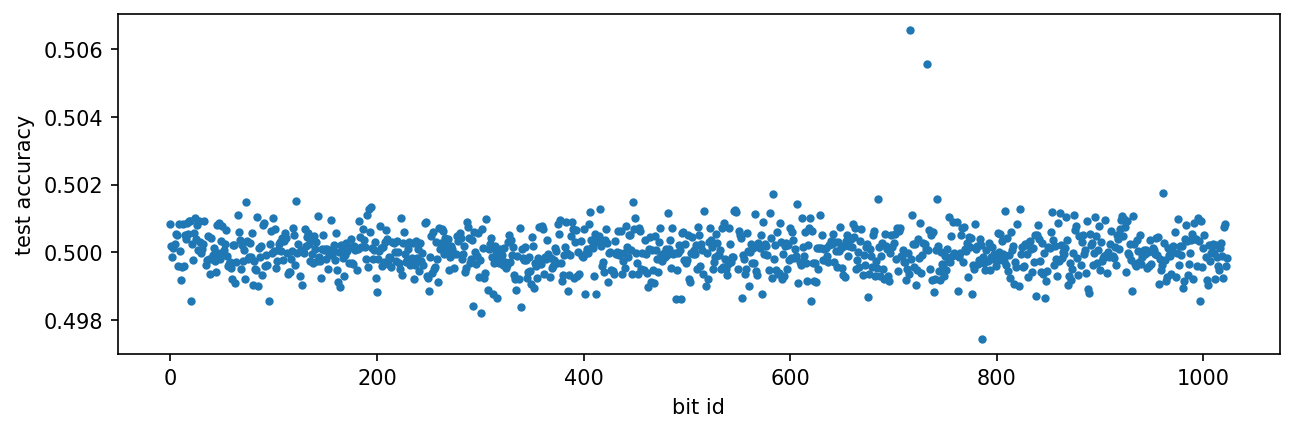

In [12]:
import matplotlib.pyplot as plt

# here we visualize the obtained `bit_accuracies`:
plt.figure(figsize=(10, 3), dpi=150)
plt.plot(bit_accuracies, 'o', markersize=3)
plt.xlabel('bit id')
plt.ylabel('test accuracy')